### Прогнозирование возраста морского ушка на основе физических измерений.

Возраст морского ушка определяется путем разрезания оболочки через конус, ее окрашивания и подсчета количества колец через микроскоп - скучная и трудоемкая задача.  Другие измерения, которые легче получить, используются для прогнозирования возраста.  Для решения этой задачи может потребоваться дополнительная информация, например, о погодных условиях и местоположении (отсюда и наличие продовольствия).


Дано имя атрибута, тип атрибута, единица измерения и
краткое описание. Количество колец - это значение для прогнозирования: либо
как непрерывное значение или как проблема классификации.

| Название | Тип данных | Измер. | Описание |
|---------|----------|------------|----|
| Пол | именной | - | M, F и I (младенец)
| Длина | непрерывная | мм. | Самое длинное измерение раковины
| Диаметр | непрерывного | мм. | перпендикулярно длине
| Высота | непрерывного | мм. | с мясом в скорлупе
| Общий вес | непрерывного | граммы | всего ушка
| Перемешанный вес | непрерывного | граммы | веса мяса
| Вес внутренностей | непрерывный | граммы | веса кишечника (после кровотечения)
| Вес скорлупы | непрерывный | граммы  | после сушки
| Кольца | целые | - | +1,5 дает возраст в годах

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC, SVR, LinearSVR, NuSVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor, AdaBoostRegressor

In [2]:
data_path = './data/abalone.csv'

In [3]:
df = pd.read_csv(data_path)

Попробуем избавить данные от избыточности.

1. общий вес, т.к. его можно вычислить как сумму Shucked Viscera Shell

In [4]:
df.drop(['Whole'], axis=1, inplace=True)

In [5]:
df.head()

,Sex,Length,Diameter,Height,Shucked,Viscera,Shell,Rings
0,M,0.455,0.365,0.095,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.0895,0.0395,0.055,7


На основе интуитивных соображений.

Размеры самок обычно наибольшие в популяции, далее за ними идут самцы (тк им нет необходимости создавать потомство), после самцов меньше обычно подрастающее поколение.

На основе этой догадки преобразуем класс Пол в цифровое значени

In [6]:
def sex_transform(s):
    s2n_map = {
        "M": 0.5,
        "F": 1,
        "I": 0
    }
    return s2n_map[s]

df.Sex = df.Sex.transform(sex_transform)

In [7]:
df.head()

,Sex,Length,Diameter,Height,Shucked,Viscera,Shell,Rings
0,0.5,0.455,0.365,0.095,0.2245,0.1010,0.150,15
1,0.5,0.350,0.265,0.090,0.0995,0.0485,0.070,7
2,1.0,0.530,0.420,0.135,0.2565,0.1415,0.210,9
3,0.5,0.440,0.365,0.125,0.2155,0.1140,0.155,10
4,0.0,0.330,0.255,0.080,0.0895,0.0395,0.055,7


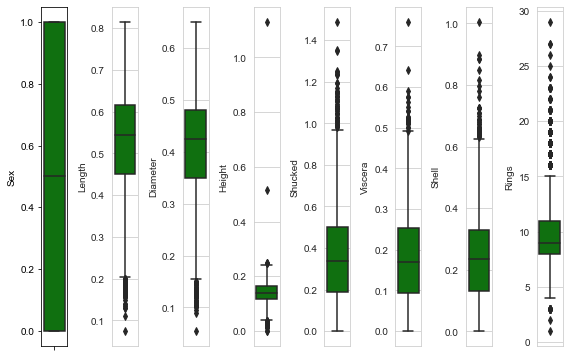

In [8]:
l = df.columns.values
number_of_columns=9
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df[l[i]],color='green',orient='v')
    plt.tight_layout()

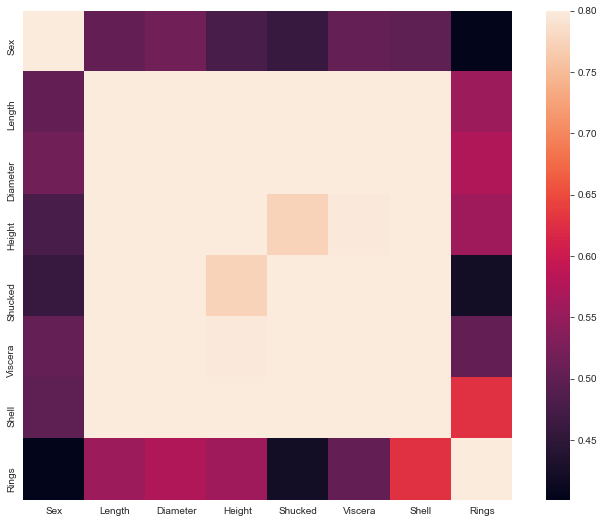

In [9]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

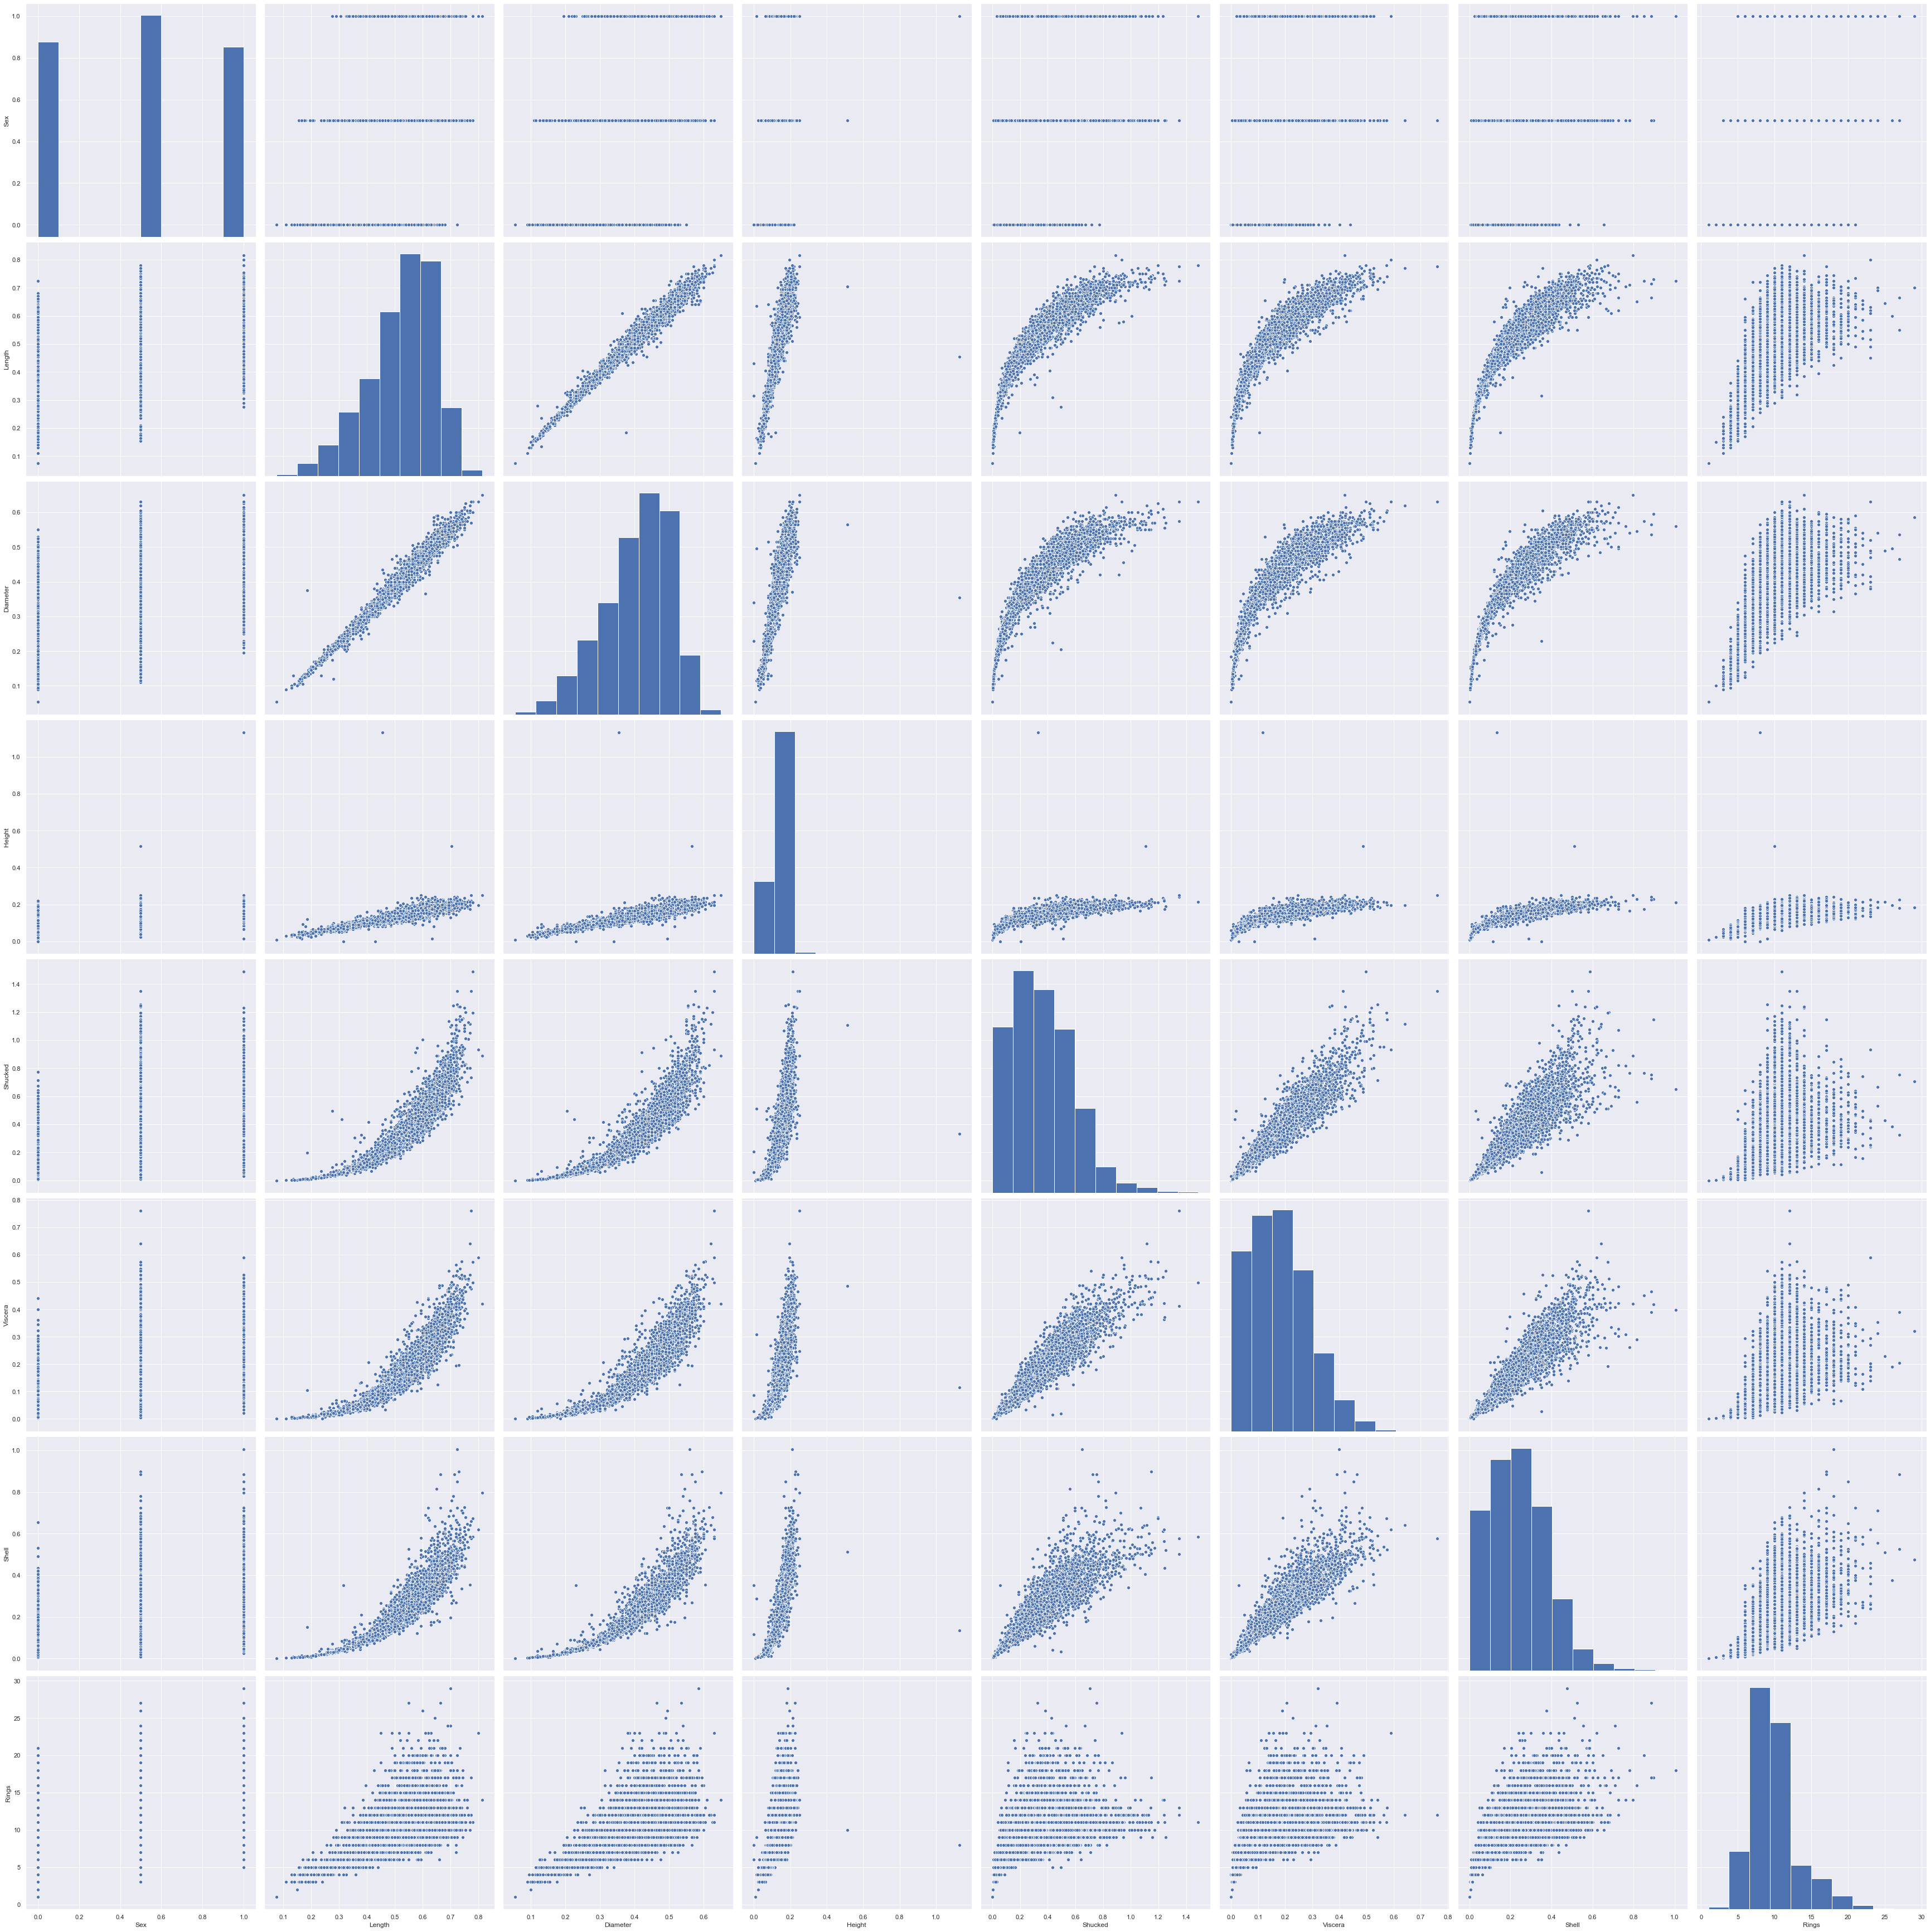

In [10]:
sns.set()
sns.pairplot(df, height = 6)
plt.show();

(картинка генерится качественная нужно просто просмотреть не через ноутбук)

Из графиков выше видно что между почти всеми параметрами прослеживается кореляция. Так же оказалась верна наша догадка насчет пола и их числовых эквивалентов.

In [11]:
X_data, Y_data = df.loc[:,:"Shell"], df["Rings"]

X_train,  X_test,  y_train,  y_test =  train_test_split(X_data, Y_data,  test_size= 0.20,  random_state= 42 )
splited_data = [X_train, y_train, X_test, y_test]

In [24]:
def test_model(train_X, train_y, test_X, test_y, model, params=[{}], sep='', show_params=True):
    for param in params:
        test_model = model(**param)
        test_model.fit(train_X, train_y)
        if params != [{}] and show_params:
            print("Параметры:", param)
        print("Оценка:", mean_absolute_error(test_model.predict(test_X), test_y))
        print(end=sep)

In [13]:
test_model(X_train, y_train, X_test, y_test, LinearRegression)

Оценка: 1.652282661406259


В нашем случае мы видим что наша модель не очень точна. Если снова взглянуть на графики то появляется предположение что в данном случае нам поможет полином второй степени.

In [14]:
poly = PolynomialFeatures(degree = 2)

test_model(poly.fit_transform(X_train), y_train, poly.transform(X_test), y_test, LinearRegression)

Оценка: 1.602994357976205


Результат практически не изменился - пришло время нейронок (нет)

Мы предполагаем что наша задача так же является задачей классификации, и тестируем различные её варианты

In [15]:
params = [
    {'kernel': 'linear', 'gamma':'auto'}, 
    {'kernel': 'poly', 'degree': 2, 'gamma':'auto'}, 
    {'kernel': 'rbf', 'gamma':'auto'}, 
    {'kernel': 'sigmoid', 'gamma':'auto'}]

test_model(X_train, y_train, X_test, y_test, SVC, params=params)

Параметры: {'kernel': 'linear', 'gamma': 'auto'}
Оценка: 1.8672248803827751
Параметры: {'kernel': 'poly', 'degree': 2, 'gamma': 'auto'}
Оценка: 2.1363636363636362
Параметры: {'kernel': 'rbf', 'gamma': 'auto'}
Оценка: 1.917464114832536
Параметры: {'kernel': 'sigmoid', 'gamma': 'auto'}
Оценка: 1.965311004784689


Возможно я где-то накосячил с параметрами, но результат хуже чем с линейной регрессией 

In [16]:
params = [
    {'kernel': 'linear', 'gamma':'auto'}, 
    {'kernel': 'poly', 'degree': 2, 'gamma':'auto'}, 
    {'kernel': 'rbf', 'gamma':'auto'}]

test_model(X_train, y_train, X_test, y_test, SVR, params=params)

Параметры: {'kernel': 'linear', 'gamma': 'auto'}
Оценка: 1.6010779218863767
Параметры: {'kernel': 'poly', 'degree': 2, 'gamma': 'auto'}
Оценка: 1.8455206719354837
Параметры: {'kernel': 'rbf', 'gamma': 'auto'}
Оценка: 1.616220338033202


In [17]:
params = [
    {'C':1.0, 'max_iter':10000}, 
    {'C':5.0, 'max_iter':10000}, 
    {'C':125.0, 'max_iter':10000},
    {'C':625.0, 'max_iter':10000},
    {'C':2500.0, 'max_iter':10000},
    {'C':12500.0, 'max_iter':10000},
    {'C':62500.0, 'max_iter':10000},]

test_model(X_train, y_train, X_test, y_test, LinearSVR, params=params)

Параметры: {'C': 1.0, 'max_iter': 10000}
Оценка: 1.6001216071343214
Параметры: {'C': 5.0, 'max_iter': 10000}
Оценка: 1.5959019231546494
Параметры: {'C': 125.0, 'max_iter': 10000}
Оценка: 1.6045745976795693


c:\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Параметры: {'C': 625.0, 'max_iter': 10000}
Оценка: 1.6063977903311004


c:\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Параметры: {'C': 2500.0, 'max_iter': 10000}
Оценка: 1.606538949235911


c:\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Параметры: {'C': 12500.0, 'max_iter': 10000}
Оценка: 1.6591037782285476
Параметры: {'C': 62500.0, 'max_iter': 10000}
Оценка: 1.8452733111140718


c:\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [18]:
params = [{'nu':x, 'gamma':'auto'} for x in [.01,.1,.2,.3,.4,.5,.6,.8,1.0]]

test_model(X_train, y_train, X_test, y_test, NuSVR, params=params)

Параметры: {'nu': 0.01, 'gamma': 'auto'}
Оценка: 3.8179688436777774
Параметры: {'nu': 0.1, 'gamma': 'auto'}
Оценка: 2.4649270198122406
Параметры: {'nu': 0.2, 'gamma': 'auto'}
Оценка: 1.9625929549409826
Параметры: {'nu': 0.3, 'gamma': 'auto'}
Оценка: 1.7707494783067783
Параметры: {'nu': 0.4, 'gamma': 'auto'}
Оценка: 1.680449655384905
Параметры: {'nu': 0.5, 'gamma': 'auto'}
Оценка: 1.6366599447984718
Параметры: {'nu': 0.6, 'gamma': 'auto'}
Оценка: 1.6225474231205297
Параметры: {'nu': 0.8, 'gamma': 'auto'}
Оценка: 1.6154432996249357
Параметры: {'nu': 1.0, 'gamma': 'auto'}
Оценка: 1.6149331706198313


Для решения задач класификации также отлично подходят деревья

In [19]:
params = [{"max_depth":x} for x in range(1,10)]
test_model(*splited_data, tree.DecisionTreeRegressor, params)

Параметры: {'max_depth': 1}
Оценка: 2.089449706375674
Параметры: {'max_depth': 2}
Оценка: 1.9400103026581252
Параметры: {'max_depth': 3}
Оценка: 1.8031662693121278
Параметры: {'max_depth': 4}
Оценка: 1.695697224199668
Параметры: {'max_depth': 5}
Оценка: 1.6257537340032628
Параметры: {'max_depth': 6}
Оценка: 1.630173074166313
Параметры: {'max_depth': 7}
Оценка: 1.6203198390350642
Параметры: {'max_depth': 8}
Оценка: 1.6383048831657472
Параметры: {'max_depth': 9}
Оценка: 1.6931701179910197


In [20]:
params = [{'random_state':42, "n_estimators":x} for x in (
    list(range(1,10,2)) + list(range(10,100,20)) + list(range(100,900,100)))
]
test_model(*splited_data, GradientBoostingRegressor, params)

Параметры: {'random_state': 42, 'n_estimators': 1}
Оценка: 2.2887001060641357
Параметры: {'random_state': 42, 'n_estimators': 3}
Оценка: 2.1392210460966536
Параметры: {'random_state': 42, 'n_estimators': 5}
Оценка: 2.019026604458836
Параметры: {'random_state': 42, 'n_estimators': 7}
Оценка: 1.9255469631493611
Параметры: {'random_state': 42, 'n_estimators': 9}
Оценка: 1.8479655518250573
Параметры: {'random_state': 42, 'n_estimators': 10}
Оценка: 1.822237094124084
Параметры: {'random_state': 42, 'n_estimators': 30}
Оценка: 1.6124881979126187
Параметры: {'random_state': 42, 'n_estimators': 50}
Оценка: 1.5906794330351408
Параметры: {'random_state': 42, 'n_estimators': 70}
Оценка: 1.5876515806335443
Параметры: {'random_state': 42, 'n_estimators': 90}
Оценка: 1.5888367352294361
Параметры: {'random_state': 42, 'n_estimators': 100}
Оценка: 1.5895295737014024
Параметры: {'random_state': 42, 'n_estimators': 200}
Оценка: 1.607880202462231
Параметры: {'random_state': 42, 'n_estimators': 300}
Оценк

In [21]:
params = [{'random_state':42, "n_estimators":x} for x in (
    list(range(1,10,2)) + list(range(10,100,20)) + list(range(100,900,100)))
]

test_model(*splited_data, RandomForestRegressor, params)

Параметры: {'random_state': 42, 'n_estimators': 1}
Оценка: 2.0574162679425836
Параметры: {'random_state': 42, 'n_estimators': 3}
Оценка: 1.7886762360446573
Параметры: {'random_state': 42, 'n_estimators': 5}
Оценка: 1.7177033492822966
Параметры: {'random_state': 42, 'n_estimators': 7}
Оценка: 1.7084757347915243
Параметры: {'random_state': 42, 'n_estimators': 9}
Оценка: 1.6735778841042
Параметры: {'random_state': 42, 'n_estimators': 10}
Оценка: 1.6717703349282296
Параметры: {'random_state': 42, 'n_estimators': 30}
Оценка: 1.6340510366826155
Параметры: {'random_state': 42, 'n_estimators': 50}
Оценка: 1.6197368421052631
Параметры: {'random_state': 42, 'n_estimators': 70}
Оценка: 1.6207792207792207
Параметры: {'random_state': 42, 'n_estimators': 90}
Оценка: 1.6207070707070705
Параметры: {'random_state': 42, 'n_estimators': 100}
Оценка: 1.6225119617224881
Параметры: {'random_state': 42, 'n_estimators': 200}
Оценка: 1.6108552631578947
Параметры: {'random_state': 42, 'n_estimators': 300}
Оценк

In [22]:
params = [{'random_state':42, "n_estimators":x} for x in (
    list(range(1,10,2)) + list(range(10,100,20)) + [100, 200])
]
test_model(*splited_data, AdaBoostRegressor, params)

Параметры: {'random_state': 42, 'n_estimators': 1}
Оценка: 1.792920441089259
Параметры: {'random_state': 42, 'n_estimators': 3}
Оценка: 1.7858829564269003
Параметры: {'random_state': 42, 'n_estimators': 5}
Оценка: 1.8541696867586082
Параметры: {'random_state': 42, 'n_estimators': 7}
Оценка: 1.9292596918956613
Параметры: {'random_state': 42, 'n_estimators': 9}
Оценка: 1.985623164625785
Параметры: {'random_state': 42, 'n_estimators': 10}
Оценка: 2.026924111972218
Параметры: {'random_state': 42, 'n_estimators': 30}
Оценка: 2.4301538505817954
Параметры: {'random_state': 42, 'n_estimators': 50}
Оценка: 2.65468101276089
Параметры: {'random_state': 42, 'n_estimators': 70}
Оценка: 2.7292594296891517
Параметры: {'random_state': 42, 'n_estimators': 90}
Оценка: 2.732670796990721
Параметры: {'random_state': 42, 'n_estimators': 100}
Оценка: 2.7674608564780425
Параметры: {'random_state': 42, 'n_estimators': 200}
Оценка: 2.766038244838369


In [25]:
m1 = GradientBoostingRegressor(random_state = 42, n_estimators=95)
m2 = RandomForestRegressor(random_state = 42, n_estimators=300)
m3 = LinearRegression()
params = [
    {'estimators':[('gb', m1), ('rf', m2), ('lr', m3)]},
    {'estimators':[('gb', m1), ('rf', m2)]},
    {'estimators':[('gb', m1), ('lr', m3)]},
    {'estimators':[('rf', m2), ('lr', m3)]}
]

test_model(*splited_data, VotingRegressor, params, sep="\n\n", show_params=False)

Оценка: 1.5702080252027202


Оценка: 1.581299075070658


Оценка: 1.5904403446335038


Оценка: 1.5786854777997288




Теперь можно попробовать и нейросети

Далее все строится только на моих предположениях о том как выглядит функция в реале и интуиции

In [69]:
import tensorflow as tf
import tensorflow.keras as keras
import datetime

In [70]:
model = keras.models.Sequential([
    keras.layers.InputLayer(X_train.shape[1]),
    keras.layers.Dense(10, activation='sigmoid'),
    keras.layers.Dense(1)
])

In [71]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 10)                80        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 11        
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


In [72]:
model.compile(optimizer='adam',
                        loss='mean_absolute_error',
                        metrics=['mae'])

In [77]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
105/105 [==============================] - 0s 3ms/step - loss: 3.9647 - mae: 3.9647
Epoch 2/20
105/105 [==============================] - 0s 3ms/step - loss: 3.1373 - mae: 3.1373
Epoch 3/20
105/105 [==============================] - 0s 3ms/step - loss: 2.5609 - mae: 2.5609
Epoch 4/20
105/105 [==============================] - 0s 4ms/step - loss: 2.2657 - mae: 2.2657
Epoch 5/20
105/105 [==============================] - 0s 4ms/step - loss: 2.1557 - mae: 2.1557
Epoch 6/20
105/105 [==============================] - 0s 4ms/step - loss: 2.1192 - mae: 2.1192
Epoch 7/20
105/105 [==============================] - 0s 4ms/step - loss: 2.0919 - mae: 2.0919
Epoch 8/20
105/105 [==============================] - 0s 3ms/step - loss: 2.0663 - mae: 2.0663
Epoch 9/20
105/105 [==============================] - 0s 3ms/step - loss: 2.0431 - mae: 2.0431
Epoch 10/20
105/105 [==============================] - 0s 3ms/step - loss: 2.0215 - mae: 2.0215
Epoch 11/20
105/105 [============================

In [78]:
print("Оценка:", mean_absolute_error(model.predict(X_test), y_test))

Оценка: 1.8340494096564335


Хуже чем у регресии :(